<center><h1> Optimal Portfoilio Selection </h1></center>

<center> <h3> Project on course Optimization Methods and NLA </h3> </center>

### *Authors*: 
 * <font size=3> Oleg Gorodnitskii </font> 
 * <font size=3> Dmytro Fedoriaka </font>
 * <font size=3> Rasul Khasianov </font>


<center> <h3> Skoltech, 2017</h3> </center>


<center><h1> Introduction </h1></center>

1. <font size=3> <b> Asset </b> $-$ an investment instrument that can be bought and sold. </font> 
2. <font size=3> Suppose we purchase an asset for $x(0)$ dollars on one date and then later sell it for $x(1)$ dollars and there are $N$ risky assets, whose <b> rates of returns </b> are given by random Variables $R_1, \dots, R_N$:</font> 

<font size=3>$$R_n = \frac{x_n(1) - x_n(0)}{x_n(0)},\; n = 1, \dots, N $$</font> 

3. <font size=3> Let $w = (w_1, \dots, w_N)^T, \;w_n$ denotes the proportion of wealth invested in asset n. The <b> rate of return of the portfolio </b> is </font>

<font size=3>$$R_P = \sum_{n=1}^{N} w_nR_n, \text{ where } \sum_{n=1}^N w_n \leq 1,\; w_n \geq 0 $$</font>


<center><font size=5, color=#333399> The goal: to choose the portfolio weighting factors <b> optimally </b>! </font> </center>



<center><h1> Markowitz Mean-Variance Analysis </h1></center>

<font size=3>For a given portfolio $w$, we can compute the mean and the variance of the portfolio return as:</font>

<font size=3>
\begin{align}
&\mathbb{E} [R] = \sum_{i=1}^N w_i R_i = w^T R\\
&\mathrm{Var[R]} = \sum_{i=1}^N \sum_{j=1}^N w_i \sigma_{ij} w_j = w^T \Sigma w
\end{align}
</font>

<center> <font size=3> <i>For <b> arbitrary </b> weigths we will get the following results of means and variances:</i> </font></center>

![MVA](../data/img1.png)

<center><font size=4> <b>What is the efficient portfolio? </b> </font></center>

<center><h1> Mean-Variance efficient portfolio </h1></center>
<br><font size=3>
    A portfolio $w^*$ is said to be <b> mean-variance efficient </b> if there exists no portfolio $w$ with:</font>
    
<font size=3>$$\mu_P \geq \mu^* \text{ and } \sigma^2_P \leq {\sigma^*}^2$$</font>

<font size=3>That is, you cannot find a portfolio that has a higher return and lower risk than those for an efficient portfolio.
</font>
![MVA](../data/img2.png)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx
from cvxpy import *
%matplotlib inline

In [2]:
# Name of train/test dataset. 'data', 'nyse_each_50','nyse_each_10' or 'nyse'
DATASET_NAME = 'data'

# Period, on which we will invest.
PERIOD = 55

# Set of lambda parameters, which we will check.
LAMBDA_RANGE = [0.01, 0.1, 0.5, 1, 2]

<center><h1> Dataset: historical 2014 prices for p = 22 securities </h1></center>
![MVA](../data/img3.png)


In [3]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_file = os.path.join(data_folder, DATASET_NAME + '_train.csv')
test_file = os.path.join(data_folder, DATASET_NAME + '_test.csv')

In [4]:
# Reading data.
data = pd.read_csv(train_file)

In [5]:
# Extract prices and dates.

sequrity_ids = data.columns[1:]
dates = [datetime.strptime(d, '%Y-%m-%d') for d in data['Date']]
prices = np.array(data[sequrity_ids]).T

# Covariation matrix.
cov = np.corrcoef(prices)

# Number of sequrities.
N = len(sequrity_ids)

# Number of time moments in train data.
T = len(dates) 

<center><h3> Data: prices from 2007 to 2015 years </h3></center>

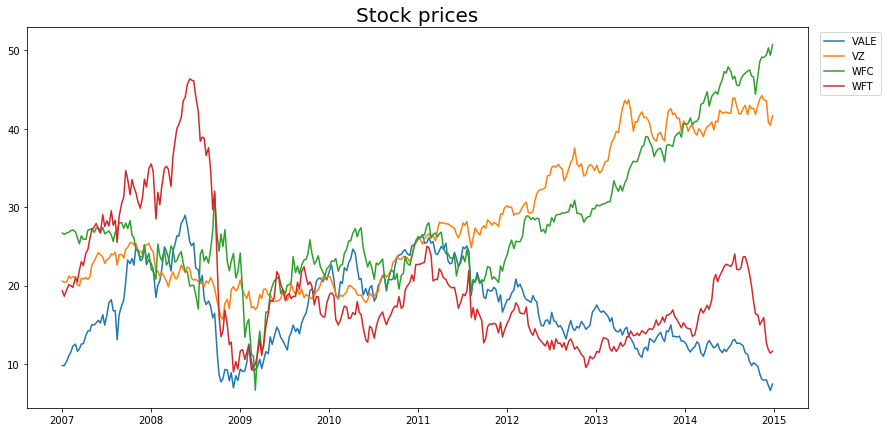

In [6]:
# Visualize some prices.

plt.figure(figsize=(14,7))
seq_to_show = sequrity_ids[-4:]

for seq in seq_to_show:
    plt.plot(dates[::6], data[seq][::6], label = seq)
plt.legend( bbox_to_anchor=(1.1, 1))
plt.title("Stock prices", fontsize=20)
plt.show()

<center><h3> Covariation matrix </h3></center>

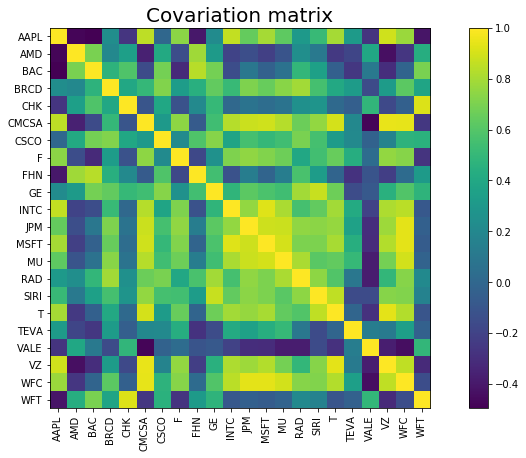

In [7]:
# Visualize covariation matrix.
plt.figure(figsize=(14,7))
plt.imshow(cov, interpolation='none')
plt.colorbar()
plt.xticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='vertical')
plt.yticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='horizontal')
plt.title("Covariation matrix", fontsize=20)
plt.show()

# Prediction of future prices
Here we use **ARIMA** (autoregressive integrated moving average) model to predict future points in the series.

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt

def test_stationarity(timeseries):
   
    dftest = adfuller(timeseries, autolag='AIC')
    return (dftest[0], dftest[4]['5%'])

def stationarize(timeseries):
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log - timeseries_log.shift()
    timeseries_log_diff.dropna(inplace=True)
    return timeseries_log_diff

def check_stationarity(data):
    for sym in list(data):
        print(test_stationarity(stationarize(data[sym])))
        
    
def predict_on_period(timeseries, period):
    model = ARIMA(timeseries, order=(2, 1, 1))  
    results_ARIMA = model.fit(disp=-1) 
    forecasts = results_ARIMA.forecast(period)
    return forecasts[0]

def pred_arima(data, period):
    
    prices_pred = []
    for sym in list(data):
        timeseries_stat = stationarize(data[sym])
        prices_pred.append(np.sum(predict_on_period(timeseries_stat, period))+np.log(data[sym][-1]))
    
    return np.exp(prices_pred)


def to_ts(data):
    data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')
    data_indx = data.set_index('Date')
    return data_indx

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
# This suppresses warnings.
import warnings
warnings.simplefilter('ignore')

In [10]:
predictions = pred_arima(to_ts(data), PERIOD)
print(predictions)

[ 111.86791657    2.45709132   18.46824546   12.18746454   19.02432335
   29.49201011   26.93000643   13.2619115    13.86733908   24.40181356
   35.25693021   60.92936554   44.91478879   39.55863499    9.01376494
    3.51790959   29.04394076   55.46253504    6.29906257   40.83648785
   53.60806138   10.89747106]


<center><h2>  Results by ARIMA prediction </h2></center>
![MVA](../data/img4.png)

<center><h2> Optimization formulation </h2></center>
<br>
<font size=3>
In order to forecast the best protfolio going forward:
\begin{align}
\min_w\; & w\Sigma w \\
s.t. \;&\; R^T w \geq p\\
&\sum_{i} w_i = 1
\end{align}
</font>

<font size=4> <b> Idea</b>: minimize risks </font>

In [11]:
# Calculates profit if we buy sequrities at time_buy, sell them
# at time_sell, spend x[i] part of capital on i-rh security.
# Assumes that initial capital is equal to 1.
def count_profit(prices, date_buy, date_sell, x):    
    prices_at_buy = prices[:, date_buy]
    prices_at_sell = prices[:, date_sell]
    capital_spent = np.sum(x)
    amount_bought = x / prices_at_buy
    revenue = np.dot(amount_bought, prices_at_sell)
    return revenue - np.sum(x)

# Calculates real profit on test data.
test_prices = None
def count_real_profit(portfolio, period):
    global test_prices 
    if test_prices is None:         # This is to ensure we don't read CSV each time we count profit
        data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
        test_data_file = os.path.join(data_folder, DATASET_NAME + '_test.csv')
        test_data = pd.read_csv(test_data_file)
        test_prices = np.array(test_data[sequrity_ids]).T
    return count_profit(test_prices, 0, period, portfolio)

# prices - numpy.array (N x T) of known prices (N - number of sequritites, T - number of time moments).
# date_buy - index of row in prices, which corresponds to buying date.
# l - 'lambda' parameter in objective.
# predicted_prices - predicted/known prices on day of selling, from external predictor.
#                    Must be arranged in the same order, as columns in prices.
def get_optimal_portfoilio_for_known_predictions(prices, date_buy, l, predicted_prices):
    # Calculating profitabilities.
    r = np.array([
        (predicted_prices[i] - prices[i, date_buy]) / prices[i, date_buy] 
        for i in range(N)
    ])
    cov = np.corrcoef(prices[:,:date_buy+1])
    return get_optimal_portfolio(r, cov, l)

def portfolio_info(portfolio, period):
    portfolio_real = portfolio.copy()
    portfolio = np.abs(portfolio)
    plt.figure(figsize=(17,4))
    # Show portfolio as pie chart.
    inv_seq = []
    for i in range(N):
        if portfolio[i] > 1e-2:
            inv_seq.append((portfolio[i], sequrity_ids[i]))
    inv_seq.sort(reverse=True)
    non_zero_inv = len(inv_seq)
    fracs = [inv_seq[i][0] for i in range(non_zero_inv)]
    labels = [inv_seq[i][1] for i in range(non_zero_inv)]
    plt.subplot(1, 2, 1)
    plt.pie(fracs, labels=labels, radius=0.9, labeldistance=1.3, rotatelabels=True)
    plt.title('Portfolio', fontsize = 20)
    
    # Model that we invest according to portfolio now and sell sequrities later,
    # varying period between buying and selling.
    period_range = range(period)
    profits = [count_real_profit(portfolio, per) for per in period_range]
    plt.subplot(1, 2, 2)
    plt.plot(period_range, profits)
    plt.xlabel("Period", fontsize = 15)
    plt.ylabel("Profit", fontsize = 15)
    plt.title('Portfolio profitability over time', fontsize = 20)
    plt.show()
    
    print("Profit on test data in %d steps: %f%%" % (period, count_real_profit(portfolio_real, period)*100))
    
def get_mean_variance(prices, date_buy, predicted_prices, portfolio, period):
    # Calculating profitabilities.
    r = np.array([
        (predicted_prices[i] - prices[i, date_buy]) / prices[i, date_buy] 
        for i in range(N)
    ])
    cov = np.corrcoef(prices[:,:date_buy+1])
    return r.T @ portfolio, portfolio.T @ cov @ portfolio, count_real_profit(portfolio, period)*100


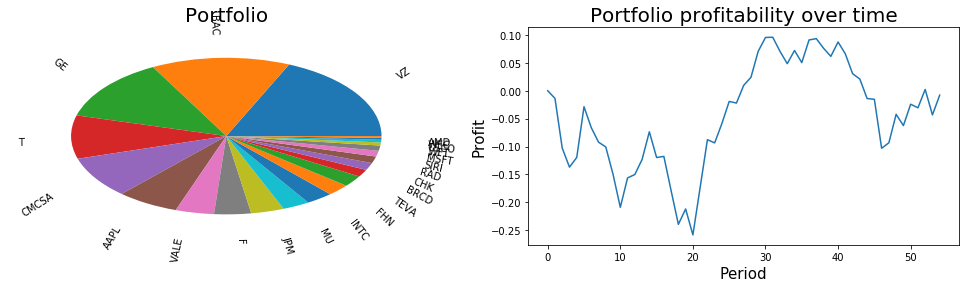

Profit on test data in 55 steps: 2.311607%


In [12]:
def get_optimal_portfolio(r, cov, p):
    x = cvx.Variable(N)
    
    objective = cvx.Minimize(cvx.quad_form(x, cov))
    constraints = [sum_entries(cvx.diag(r) @ x) >= p, cvx.sum_entries(x) == 1]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

#predictions = pred_arima(to_ts(data), PERIOD)

p = 0.001
opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, p, predictions)
portfolio_info(opt_portfolio, PERIOD)

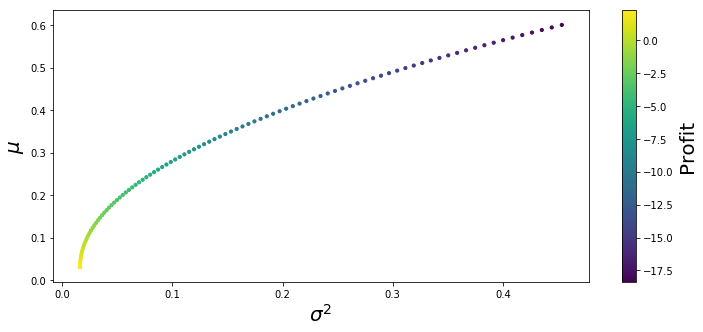

In [13]:
# Collect results

results_1 = []
for p in np.linspace(0.01, 0.6, 100):
    opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, p, predictions)
    mean, var, profit = get_mean_variance(prices, T-1, predictions, opt_portfolio, PERIOD)
    results_1.append([mean, var, profit])
    
results_1 = np.array(results_1)
plt.figure(figsize=(12, 5))
plt.scatter(results_1[:, 1], results_1[:, 0], c = results_1[:,2], s=10)
plt.xlabel('$\sigma^2$', fontsize=20)
plt.ylabel('$\mu$', fontsize=20)
ax = plt.colorbar();
ax.set_label(label='Profit', fontsize=20)

<center><h2> Optimization formulation: modification 1 </h2></center>
<br>
<font size=3>
In order to forecast the best protfolio going forward:
\begin{align}
\max_w\; &  R^T w  \\
s.t. \;&\; w\Sigma w \leq p\\
&\sum_{i} w_i = 1
\end{align}
</font>

<font size=4> <b> Idea</b>: maximize returns </font>

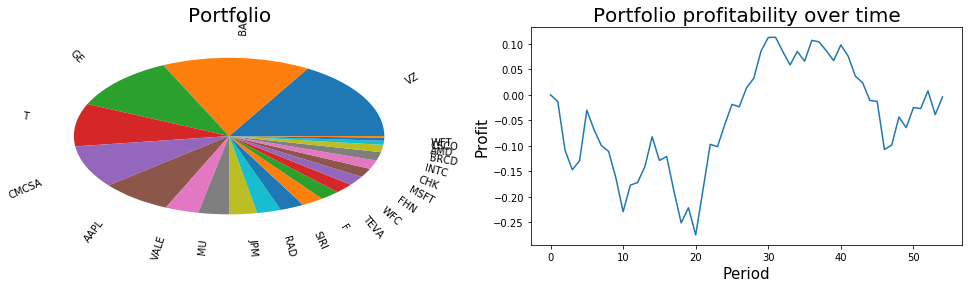

Profit on test data in 55 steps: 1.385385%


In [14]:
def get_optimal_portfolio(r, cov, p):
    x = cvx.Variable(N)
    
    objective = cvx.Maximize(sum_entries(np.diag(r) @ x))
    constraints = [cvx.quad_form(x, cov) <= p, cvx.sum_entries(x) == 1]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

#predictions = pred_arima(to_ts(data), PERIOD)

p = 0.017
opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, p, predictions)
portfolio_info(opt_portfolio, PERIOD)

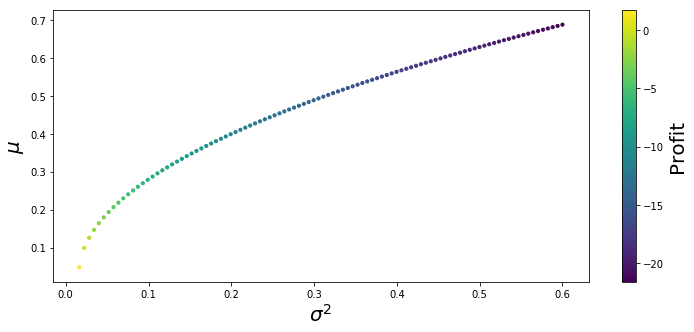

In [15]:
# Collect results

results_2 = []
for p in np.linspace(0.0165, 0.6, 100):
    opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, p, predictions)
    mean, var, profit = get_mean_variance(prices, T-1, predictions, opt_portfolio, PERIOD)
    results_2.append([mean, var, profit])
    
results_2 = np.array(results_2)
plt.figure(figsize=(12, 5))
plt.scatter(results_2[:, 1], results_2[:, 0], c = results_2[:,2], s=10)
plt.xlabel('$\sigma^2$', fontsize=20)
plt.ylabel('$\mu$', fontsize=20)
ax = plt.colorbar();
ax.set_label(label='Profit', fontsize=20);

<center><h2> Optimization formulation: modification 2 </h2></center>
<br>
<font size=3>
In order to forecast the best protfolio going forward:
\begin{align}
\max_w\; &  R^T w - \lambda  w\Sigma w \\
s.t. &\sum_{i} w_i = 1
\end{align}
</font>

<font size=4> <b> Idea</b>:  try to balance previous two objectives in a single objective function!</font>

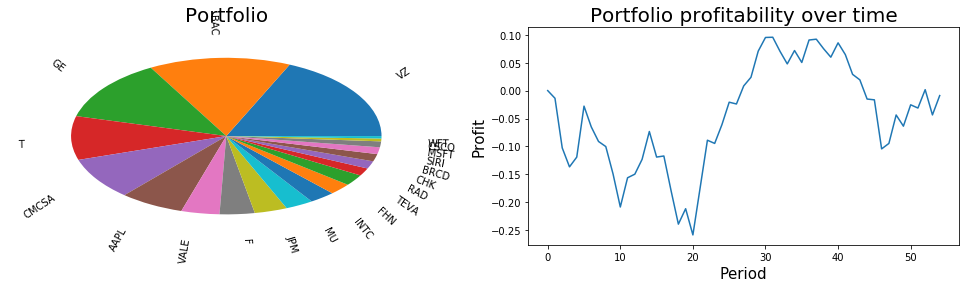

Profit on test data in 55 steps: 2.176918%


In [16]:
def get_optimal_portfolio(r, cov, l):
    x = cvx.Variable(N)
    
    objective = cvx.Maximize(r*x - l*cvx.quad_form(x, cov))
    constraints = [cvx.sum_entries(x) == 1]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

#predictions = pred_arima(to_ts(data), PERIOD)

l = 100
opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, l, predictions)
portfolio_info(opt_portfolio, PERIOD)

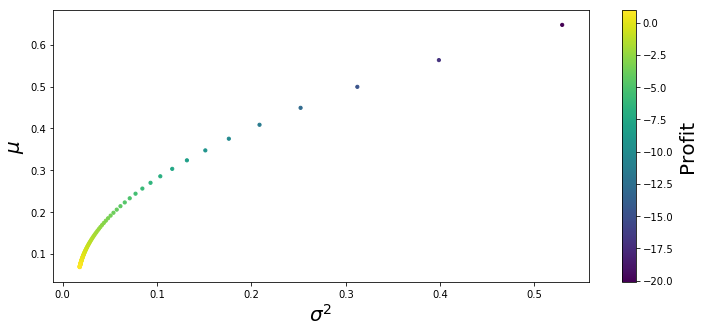

In [17]:
# Collect results

results_3 = []
for p in np.linspace(0.6, 10, 100):
    opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, p, predictions)
    mean, var, profit = get_mean_variance(prices, T-1, predictions, opt_portfolio, PERIOD)
    results_3.append([mean, var, profit])
    
results_3 = np.array(results_3)
plt.figure(figsize=(12, 5))
plt.scatter(results_3[:, 1], results_3[:, 0], c = results_3[:,2], s=10)
plt.xlabel('$\sigma^2$', fontsize=20)
plt.ylabel('$\mu$', fontsize=20)
ax = plt.colorbar();
ax.set_label(label='Profit', fontsize=20);

<center><h2> Sparse Portfolios </h2></center>
<br><font size=3>Practical investing requires balancing portfolio <b>optimality</b> and <b>simplicity</b>!</font>
 * Managing large asset positions and transacting frequently is expensive and time-consuming
 * Their <b>choice set</b> for investment opportunities <b>is massive</b> and includes exchange-traded funds (ETFs), mutual funds, and thousands of individual stocks.

<h3> How does one invest optimally while keeping the simplicity (sparsity) of a portfolio in mind?  </h3> 
<br><font size=3><b>Answer</b>: for example $l_1$ penalizing
$$L = \frac{1}{2} w^T \Sigma w - w^T \mu + \lambda \|w\|_1$$

This problem can reformulated to the form of **standard** sparse **regression** loss functions:
$$L = \frac{1}{2} \left \|L^T  w - L^{-1} \mu \right\|_2^2 + \lambda  \| w\|_1$$
where $\Sigma = L L^T$ $-$ Cholesky decomposition
</font>

## Proof:
<font size=3>
\begin{align}
F &= \frac{1}{2} w^T \Sigma w - w^T \mu + \lambda \|w\|_1 \sim\\
& \sim \frac{1}{2} \left(w - \Sigma^{-1} \mu \right)^T \Sigma \left(w - \Sigma^{-1} \mu \right) + \lambda \|w\|_1 = \\
& = \frac{1}{2} \left(w - L^{-T} L^{-1} \mu \right)^T L L^{T}  \left(w - L^{-T} L^{-1}  \mu \right) + \lambda \|w\|_1 = \\
& = \frac{1}{2} \left[ L^T \left(w - L^{-T} L^{-1} \mu \right) \right]^T  \left[ L^T \left(w - L^{-T} L^{-1} \mu \right) \right]+ \lambda \|w\|_1 = \\
& = \frac{1}{2} \left \|L^T  w - L^{-1} \mu \right\|_2^2 + \lambda  \| w\|_1
\end{align}
<font>

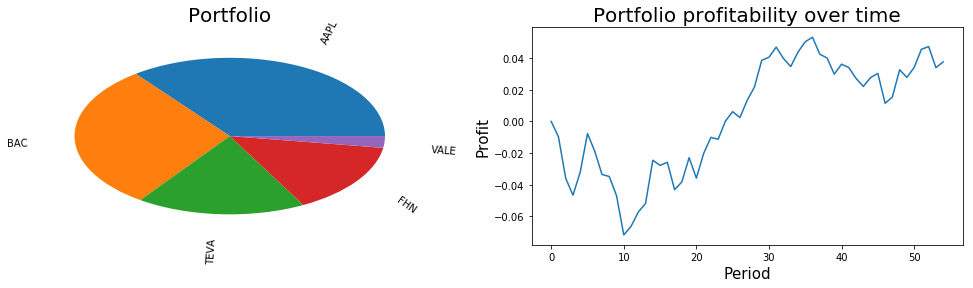

Profit on test data in 55 steps: 4.110063%


In [18]:
def get_optimal_portfolio(r, cov, l):
    x = cvx.Variable(N)
    L = np.linalg.cholesky(cov)
    
    objective = cvx.Minimize(0.5 * cvx.norm2(L.T @ x - np.linalg.inv(L) @r) ** 2 + l*cvx.norm1(x))
    constraints = [cvx.sum_entries(x) == 1]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

l = 0.09
opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, l, predictions)
portfolio_info(opt_portfolio, PERIOD)

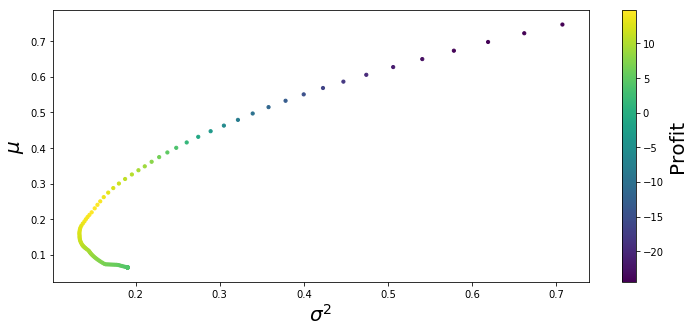

In [19]:
# Collect results

results_4 = []
for p in np.linspace(0.001, 0.1, 100):
    opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, p, predictions)
    mean, var, profit = get_mean_variance(prices, T-1, predictions, opt_portfolio, PERIOD)
    results_4.append([mean, var, profit])
    
results_4 = np.array(results_4)
plt.figure(figsize=(12,5))
plt.scatter(results_4[:, 1], results_4[:, 0], c = results_4[:,2], s=10)
plt.xlabel('$\sigma^2$', fontsize=20)
plt.ylabel('$\mu$', fontsize=20)
ax = plt.colorbar();
ax.set_label(label='Profit', fontsize=20);

<center><h2> What we have learned? </h2></center>
<font size=3> 
<ul>
  <li> Mean-Variance Optimization </li>
  <li> $l_1$ regularization to find sparse solution</li>
  <li> We faced with the problem of non-convex optimization</li>
</ul>

</font>